In [1]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test_pas = test.pop('PassengerId')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Check NA values in data frame

In [5]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Visualizing the data

<AxesSubplot:xlabel='Age', ylabel='Count'>

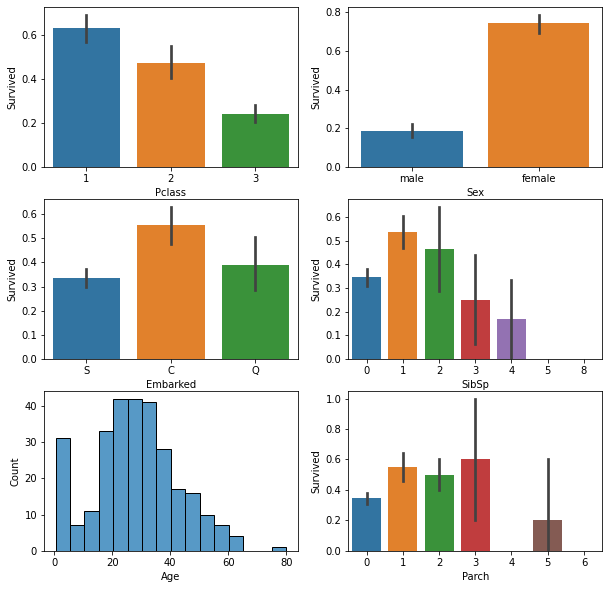

In [6]:
f, ax = plt.subplots(3,2, figsize=[10,10])
sns.barplot(x='Pclass', y='Survived', data=train, ax=ax[0,0])
sns.barplot(x='Sex', y='Survived', data=train, ax=ax[0,1])
sns.barplot(x='Embarked', y='Survived', data=train, ax=ax[1,0])
sns.barplot(x='SibSp', y='Survived', data=train, ax=ax[1,1])
sns.barplot(x='Parch', y='Survived',data=train, ax=ax[2,1])
sns.histplot(x='Age', data=train[train['Survived']==1], ax=ax[2,0])

**Observations**

1. Pclass == 1 has highest probability of surviving.
2. Females have higher chance of survival.
3. Passengers from C station have higher chance of survival.
4. People with Sibsp 1 and 2 have better chance of survival.
5. People between age 20 and 40 and infants have higher count in survived passengers.
6. Parch column with 1,2,3 has similar chance of survival.

Since there is not much conclusive evidence from plot 4 and 6, we will engineer features from Parch and Sibsp column into Family and Alone columns.(https://www.kaggle.com/l3r4nd/titanic-prediction-with-svm)

Embarked has 2 missing values, we fill them depending on their Survival class. 

In [7]:
nan_row = train[train['Embarked'].isnull()]
for i in nan_row.index:
    if train['Survived'][i] == 1:
        train['Embarked'][i] = 'C'
    else:
        train['Embarked'][i] = 'S'
    

<ipython-input-7-751cea3f012a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Embarked'][i] = 'C'


In [8]:
def get_age_group(data):
    age_group = []
    for i in range(len(data)):
        if data['Age'][i] <= 10:
            age_group.append(1)
        elif data['Age'][i] > 10 and data['Age'][i] <= 16 :
            age_group.append(2)
        elif data['Age'][i] > 16 and data['Age'][i] <= 40 :
            age_group.append(3)
        elif data['Age'][i] > 40 and data['Age'][i] < 60 :
            age_group.append(4)
        else:
            age_group.append(5)
    return age_group

In [9]:
def get_fare_group(data):
    payment = data.groupby('Pclass')['Fare'].mean()
    data.loc[(data['Fare'] < payment[3]),'FareGroup'] = 1
    data.loc[(data['Fare'] > payment[3]) & (data['Fare'] <  payment[2]),'FareGroup'] = 2
    data.loc[(data['Fare'] > payment[2]) & (data['Fare'] <  payment[1]), 'FareGroup'] = 3
    data.loc[(data['Fare'] > payment[1]),'FareGroup'] = 4
    data['FareGroup'] = data['FareGroup'].astype(int)
    

In [10]:
train['age_group'] = get_age_group(train)
test['age_group'] = get_age_group(test)

In [11]:
test['Fare'].fillna(test['Fare'].median(), inplace=True)
get_fare_group(train)
get_fare_group(test)

The above function divides the age columns into different age groups. We have divided age groups depending on the number of passengers that survived the disaster.

<AxesSubplot:xlabel='age_group', ylabel='Survived'>

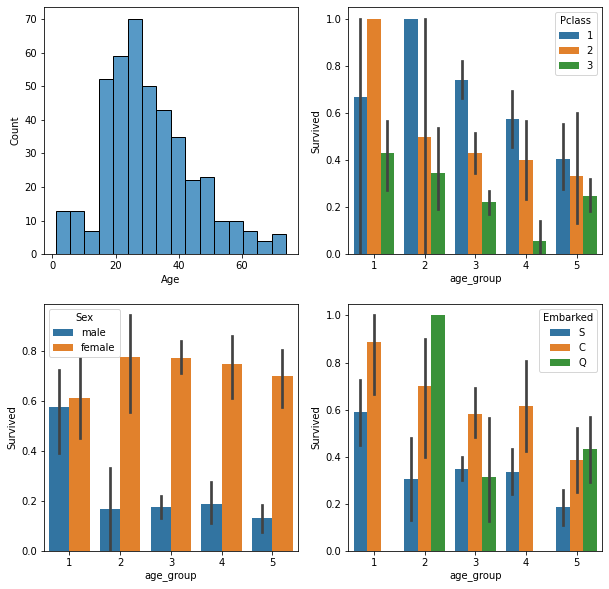

In [12]:
f, ax = plt.subplots(2,2, figsize=(10,10))
sns.histplot(x='Age', data=train[train['Survived']==0], ax=ax[0,0])
sns.barplot(x='age_group', y='Survived', data=train, hue='Pclass', ax=ax[0,1])
sns.barplot(x='age_group', y='Survived', data=train, hue='Sex', ax=ax[1,0])
sns.barplot(x='age_group', y='Survived', data=train, hue='Embarked', ax=ax[1,1])

**Observations**

7. From 5 we know that between 20 and 40 years the survival rate is high. Similarly Death rate is also high between 20 and 40 years. This is because number of passengers on board the ship are mostly between 20 and 40 years.
8. After dividing into age groups and plotting the survival rate barplot for age_group with Pclass, we see that except in age group 1 all other groups have higher survival rate for Pclass 1.
9. All age_group have higher survival rate in case of females.
10. Age group 2 and 5 have higher survival rate for passengers embarked from 'Q' station while others from 'C' station.

*Taking above observations into account we will form our decision rules to fill NA values for Age column*

For example, 

if Survived == 1:

    if Pclass == 1:
    
        age_group = 2
        
    if Pclass == 2:
    
        age_group = 1
        
    if Pclass == 3:
    
        age_group = 5

In [13]:
def fill_age_na_train(data):
    nan_row = data[data['Age'].isnull()]
    for i in nan_row.index:
        if data['Survived'][i] == 1:
            if data['Sex'][i] == 'male':
                data['age_group'][i] = 1  #male has high S.R in age_group 1.
                
            else:
                if data['Pclass'][i] == 1 and data['Embarked'][i] == 'Q':
                    data['age_group'][i] = 2 #Plot 8 and 10
                    
                elif data['Pclass'][i] == 2 and data['Embarked'][i] == 'C':
                    data['age_group'][i] = 1 #Plot 8 and 10
                    
                else:
                    data['age_group'][i] = 3 #Taking the best chance of survival because of more counts
                    
        else:
            if data['Sex'][i] == 'female':
                data['age_group'][i] = 1 #female has lowest S.R. in age_group 1.
                
            else:
                if data['Pclass'][i] == 3:
                    data['age_group'][i] = 4 #Plot 8 and 10
                    
                elif data['Embarked'][i] == 'S':
                    data['age_group'][i] = 5 #Plot 8 and 10
                    
                else:
                    data['age_group'][i] = 4 #Taking the best chance of death
                    

In [14]:
def fill_age_na_test(data):
    nan_row = data[data['Age'].isnull()]
    for i in nan_row.index:
        if data['Sex'][i] == 'male':
            if data['Pclass'][i] == 1 and data['Embarked'][i] == 'Q':
                data['age_group'][i] = 2 #Plot 8 and 10
                
            elif data['Pclass'][i] == 2 and data['Embarked'][i] == 'C':
                data['age_group'][i] = 1 #Plot 8 and 10
                
            else:
                data['age_group'][i] = 3 #Taking the best chance of survival because of more counts
                
        else:
            if data['Pclass'][i] == 3:
                data['age_group'][i] = 4 #Plot 8 and 10
                
            elif data['Embarked'][i] == 'S':
                data['age_group'][i] = 5 #Plot 8 and 10
                
            else:
                data['age_group'][i] = 4 #Taking the best chance of death
                

In [15]:
#Fill AGE missing values using decision rules
fill_age_na_train(train)

<ipython-input-13-e6488124fecf>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['age_group'][i] = 4 #Plot 8 and 10
<ipython-input-13-e6488124fecf>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['age_group'][i] = 1  #male has high S.R in age_group 1.
<ipython-input-13-e6488124fecf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['age_group'][i] = 3 #Taking the best chance of survival because of more counts
<ipython-

In [16]:
fill_age_na_test(test)

<ipython-input-14-57a558745ef4>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['age_group'][i] = 3 #Taking the best chance of survival because of more counts
<ipython-input-14-57a558745ef4>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['age_group'][i] = 5 #Plot 8 and 10
<ipython-input-14-57a558745ef4>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['age_group'][i] = 4 #Plot 8 and 10
<ipython-input-14-57a558745ef

In [17]:
train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Age', 'Fare'], axis=1, inplace=True)
test.drop(['Name', 'Ticket', 'Cabin', 'Age', 'Fare'], axis=1, inplace=True)

In [18]:
def one_hot_encoding(col):
    for i in range(len(col)):
        if col[i] == 'S':
            col1.append(1)
            col2.append(0)
            col3.append(0)
        elif col[i] == 'C':
            col1.append(0)
            col2.append(1)
            col3.append(0)
        else:
            col1.append(0)
            col2.append(0)
            col3.append(1)
        
    return col1, col2, col3

In [19]:
col1, col2, col3 = [], [], []
col1, col2, col3 = one_hot_encoding(train['Embarked'])
train['Embarked_S'] = col1
train['Embarked_C'] = col2
train['Embarked_Q'] = col3

In [20]:
col1, col2, col3 = [], [], []
col1, col2, col3 = one_hot_encoding(test['Embarked'])
test['Embarked_S'] = col1
test['Embarked_C'] = col2
test['Embarked_Q'] = col3

In [21]:
train['Sex'].replace('male', 0, inplace=True)
train['Sex'].replace('female', 1, inplace=True)
test['Sex'].replace('male', 0, inplace=True)
test['Sex'].replace('female', 1, inplace=True)

In [22]:
train.head()

,Survived,Pclass,Sex,SibSp,Parch,Embarked,age_group,FareGroup,Embarked_S,Embarked_C,Embarked_Q
0,0,3,0,1,0,S,3,1,1,0,0
1,1,1,1,1,0,C,3,3,0,1,0
2,1,3,1,0,0,S,3,1,1,0,0
3,1,1,1,1,0,S,3,3,1,0,0
4,0,3,0,0,0,S,3,1,1,0,0


In [23]:
train.drop(['Embarked'], axis=1, inplace=True)


In [24]:
test.drop(['Embarked'], axis=1, inplace=True)

In [25]:
train_y = train.pop('Survived')

In [26]:
from sklearn import preprocessing

In [27]:
X = train.values
min_max_scaler = preprocessing.MinMaxScaler()
X_norm = min_max_scaler.fit_transform(X)
X_train = pd.DataFrame(X_norm)

In [28]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

In [29]:
X = X_norm
Y = train_y

In [30]:
clf = svm.NuSVC(kernel='linear')
clf.fit(X,Y)

NuSVC(kernel='linear')

In [31]:
score = cross_val_score(clf, X, Y, scoring='accuracy', cv=10, n_jobs=-1).mean()

In [32]:
score

0.786729088639201

In [33]:
test.head()

,Pclass,Sex,SibSp,Parch,age_group,FareGroup,Embarked_S,Embarked_C,Embarked_Q
0,3,0,0,0,3,1,0,0,1
1,3,1,1,0,4,1,1,0,0
2,2,0,0,0,5,1,0,0,1
3,3,0,0,0,3,1,1,0,0
4,3,1,1,1,3,1,1,0,0


In [34]:
X_t = test.values
X_norm = min_max_scaler.fit_transform(X_t)
X_test = pd.DataFrame(X_norm)

In [35]:
pred = clf.predict(X_test)

In [36]:
prediction = pd.DataFrame({'PassengerId':test_pas, 'Survived':pred})

In [37]:
prediction.to_csv('Results.csv', index=False)

**XGBoost**

In [38]:
from xgboost import XGBClassifier

In [39]:
clf_xg = XGBClassifier(encoder=False)

In [40]:
clf_xg.fit(X,Y)

[01:01:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "encoder" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:01:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ajayc\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, encoder=False, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [41]:
score = cross_val_score(clf_xg, X, Y, scoring='accuracy', cv=10, n_jobs=-1).mean()

In [42]:
pred = clf.predict(X_test)

In [43]:
prediction = pd.DataFrame({'PassengerId':test_pas, 'Survived':pred})

In [44]:
prediction.to_csv('Results.csv', index=False)

In [45]:
score

0.8294382022471909